# Mengimport library yang akan digunakan

In [1]:
import os
import re
import numpy as np
import pandas as pd
import xarray as xr
import earthpy as et
import seaborn as sns
import rasterio as rio
import geopandas as gpd
import rioxarray as rxr

from numpy import ma
from glob import glob
from shapely import speedups
from earthpy import mask as em
from earthpy import plot as ep
from rasterio import plot, mask
from earthpy import spatial as es
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches, colors

from rasterio.crs import CRS
from shapely.geometry import mapping
from earthpy.spatial import bytescale
from matplotlib.colors import ListedColormap, BoundaryNorm

speedups.disable()

# Menampilkan Data Cloud Free

In [2]:
df = pd.read_csv("dataset/NDVI.csv")
df = df.loc[df["clear_area_pc"] >= 100]
df

,date,clear_area_km,clear_area_pc
15,2015-08-31,116.8137,100.0
34,2016-06-30,116.8209,100.0
58,2017-07-19,116.8137,100.0
84,2018-09-24,116.8182,100.0
102,2019-07-25,116.8209,100.0
105,2019-09-11,116.8146,100.0
118,2020-05-24,116.8218,100.0


# Mengimport dan membaca citra

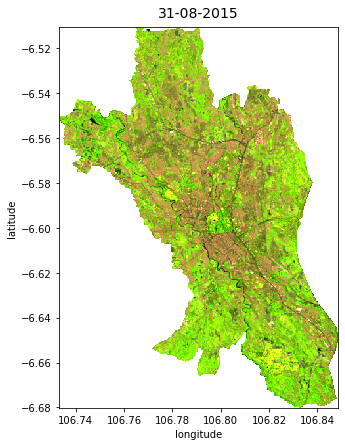

In [3]:
preprocessed_dir = "output/preprocessed/2015-08-31"
band_names = (4, 5, 6)
coor_ref = "EPSG:4326"

preprocessed_band = dict()

for i in band_names:
    with rxr.open_rasterio(f"{preprocessed_dir}/B{i}.TIF", masked=True) as raster:
        preprocessed_band[i] = raster.squeeze().rio.reproject(CRS.from_string(coor_ref))
    
band_stacks = (6, 5, 4)
vmin, vmax = 0.03, 0.97

year, month, date = preprocessed_dir[20:24], preprocessed_dir[25:27], preprocessed_dir[28:30]
time = f"{year}-{month}-{date}"


preprocessed_rgb_img = xr.concat([preprocessed_band[i] for i in band_stacks], dim="band")

fig, ax = plt.subplots(figsize=(5, 7))

preprocessed_rgb_img.plot.imshow(ax=ax,
                                 vmin=preprocessed_rgb_img.quantile(vmin),
                                 vmax=preprocessed_rgb_img.quantile(vmax))
ax.set_title(f"{time[8:]}-{time[5:7]}-{time[:4]}", fontsize=14, pad=10)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

plt.show()

# Mencari Nilai Reflectance dan Nilai NDVI berdasarkan Point Of Area

In [4]:
def search_coordinates(coordinates):
    
    lat_dist_arr = list() 
    long_dist_arr = list()
    lat_index_arr = list()
    long_index_arr = list()
    reflectance_arr = list()
    ndvi_arr = list()

    for i in range(len(coordinates)):
        lat_dist = dict()
        long_dist = dict()
        for j in range(2):
            for k, l in enumerate(preprocessed_band[band_names[0]]["y"].values):
                lat_dist[k] = abs(coordinates[i][0] - l) 
            for k, l in enumerate(preprocessed_band[band_names[0]]["x"].values):
                long_dist[k] = abs(coordinates[i][1] - l)
        lat_dist_arr.append(lat_dist)
        long_dist_arr.append(long_dist)
        lat_index = list(lat_dist.keys())[list(lat_dist.values()).index(sorted(lat_dist.values())[0])] 
        long_index = list(long_dist.keys())[list(long_dist.values()).index(sorted(long_dist.values())[0])]
        lat_index_arr.append(lat_index)
        long_index_arr.append(long_index)
        temp_reflectance = list()
        for j in band_names:
            reflectance = preprocessed_band[j][lat_index_arr[i]][long_index_arr[i]].values
            temp_reflectance.append(reflectance)
        reflectance_arr.append(temp_reflectance)
        ndvi = (reflectance_arr[i][1]-reflectance_arr[i][0]) / (reflectance_arr[i][1]+reflectance_arr[i][0])
        ndvi_arr.append(ndvi)
        
    return {
        "lat_dist": lat_dist_arr,
        "long_dist": long_dist_arr,
        "lat_index": lat_index_arr,
        "long_index": long_dist_arr,
        "reflectance": reflectance_arr,
        "ndvi": ndvi_arr
    }

In [5]:
veg_coor =[[-6.596188, 106.799455],
           [-6.609774, 106.7866633],
           [-6.558749, 106.799572],
           [-6.551197, 106.750441],
           [-6.568829, 106.759833],
           [-6.569788, 106.761883],
           [-6.555375, 106.752453],
           [-6.558087, 106.756502],
           [-6.555440, 106.779765],
           [-6.580770, 106.819485],
           [-6.596272, 106.797236],
           [-6.576455, 106.766145],
           [-6.569215, 106.801809],
           [-6.578263, 106.765779],
           [-6.566546, 106.746324],
           [-6.667776, 106.834601],
           [-6.665890, 106.839789],
           [-6.576626, 106.788186],
           [-6.577909, 106.773171],
           [-6.596352, 106.782484]
         ]

In [6]:
veg = search_coordinates(veg_coor)
veg_reflectance = veg["reflectance"]
veg_ndvi = np.array(veg["ndvi"])

non_veg = search_coordinates(non_veg_coor)
non_veg_reflectance = non_veg["reflectance"]
non_veg_ndvi = np.array(non_veg["ndvi"])

In [7]:
veg_ndvi

array([0.7527379 , 0.76216996, 0.54913867, 0.7581682 , 0.729957  ,
       0.71960634, 0.7603265 , 0.70578176, 0.65727526, 0.76887923,
       0.67049485, 0.6798578 , 0.40336993, 0.81322795, 0.5118081 ,
       0.33195662, 0.67345965, 0.39268312, 0.67367494, 0.76821244],
      dtype=float32)

In [8]:
non_veg_coor = [[-6.599027, 106.792816],
                [-6.565630, 106.792436],
                [-6.599445, 106.792275],
                [-6.596313, 106.783191],
                [-6.590826, 106.800745],
                [-6.5957429,106.8048346],
                [-6.570729, 106.790088],
                [-6.573477, 106.794066],
                [-6.573846, 106.791928],
                [-6.574271, 106.790980],
                [-6.604540, 106.792558],
                [-6.601440, 106.807422],
                [-6.5952514,106.7891444],
                [-6.607350, 106.805656],
                [-6.596814, 106.793791],
                [-6.595311, 106.791490],
                [-6.593248, 106.784353],
                [-6.592609, 106.784068],
                [-6.581046, 106.775309],
                [-6.593539, 106.787896]
               ]

In [9]:
non_veg = search_coordinates(non_veg_coor)
non_veg_reflectance = non_veg["reflectance"]
non_veg_ndvi = np.array(non_veg["ndvi"])

In [10]:
non_veg_ndvi

array([0.19760367, 0.22076914, 0.20368706, 0.49122134, 0.41475078,
       0.20518939, 0.23237924, 0.2804472 , 0.28865722, 0.20132715,
       0.25697896, 0.35208994, 0.18703118, 0.35141554, 0.4788615 ,
       0.3232967 , 0.18795636, 0.16818815, 0.27702036, 0.11429258],
      dtype=float32)

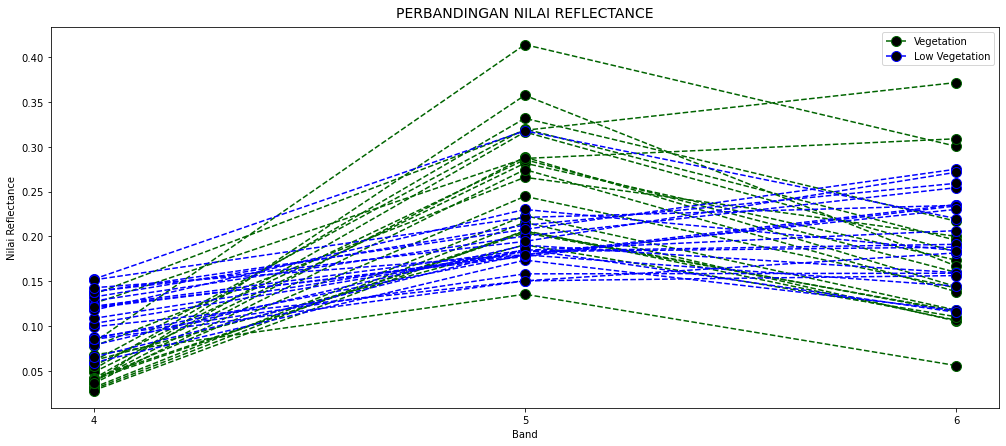

In [11]:
fig, ax = plt.subplots(figsize=(17, 7))

x_label = np.array(band_names).astype(str)

for i in veg_reflectance:
    ax.plot(x_label, i, label="Vegetation", 
            color='darkgreen', linestyle='dashed', marker='o',markerfacecolor='black', markersize=10)
for i in non_veg_reflectance:
    ax.plot(x_label, i, label="Low Vegetation", 
            color='blue', linestyle='dashed', marker='o',markerfacecolor='black', markersize=10)
    
ax.set_xlabel("Band")
ax.set_ylabel("Nilai Reflectance")
ax.set_title("PERBANDINGAN NILAI REFLECTANCE", fontsize=14, pad=10)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.show() 

Pada Vegetasi akan banyak energi yang diserap dikarenakan adanya penyerapan klorofil yang kuat guna untuk proses fotosintesis, dan memantulkan sedikit energi. Pada band 4 nilai reflektan yang dipantulkan cenderung lebih sedikit dikarenakan panjang gelombang pada band 4 sebesar 0.64 – 0.67 mikrometer yang bisa digunakan untuk mendeteksi sudut vegetasi. Pada band 5 (NIR / Inframerah dekat), vegetasi hijau yang sehat akan memberikan pantulan yang sangat tinggi dikarenakan panjang gelombang pada band 5 sebesar 0.85 – 0.88 mikrometer yang bisa digunakan untuk mendeteksi biomasa (bahan organik yang dihasilkan oleh proses fotosintesis). Pada band 5 faktor yang mempengaruhi tinggi dan rendahnya nilai reflektan disebabkan oleh struktur internal daun seperti kerapatan kanopi dan lebar daun (Jaringan mesofil gabus).(Lillesand et al., 2008) Dimana didalam jaringan mesofil gabus terdapat  efitokular lilin yang mampu meningkatan pantulan NIR sebanyak 60%. Pada band 6 nilai pantulan lebih rendah dibandingkan band 5 dikarenakan pada panjang gelombang 0.97, 1.19, 1.45, 1.94 dan 2.6 penyerapan air cenderung lebih kuat.

Vegetasi memberikan respon spektral pada spektrum tampak dengan banyak energi yang diserap dan sangat sedikit yang ditransmisikan. Panjang gelombang 0,54 – 0,59 mikrometer yang merupakan spektrum hijau ialah daerah serapan klorofil sehingga pantulan yang dihasilkan cukup tinggi. Pada spektrum inframerah dekat, vegetasi hijau yang sehat akan memberikan pantulan yang sangat tinggi (Hoffer, 1978).

# Pemisahan Nilai Ambang Batas (threshold) pada masing-masing kelas

Adapun formula yang digunakan yaitu:

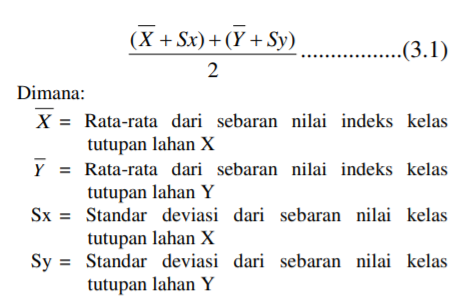

In [35]:
import statistics
X_mean = statistics.mean(veg_ndvi)

list_varian = []
for bilangan in veg_ndvi:
    list_varian.append(
        (bilangan - X_mean) ** 2
    )

varian = sum(list_varian) / len(veg_ndvi)

X_std = statistics.sqrt(varian)

print("X_mean", X_mean)
print("X_Std", X_std)

Y_mean = statistics.mean(non_veg_ndvi)

list_varian = []
for bilangan in non_veg_ndvi:
    list_varian.append(
        (bilangan - Y_mean) ** 2
    )

varian = sum(list_varian) / len(non_veg_ndvi)

Y_std = statistics.sqrt(varian)
print("Y_mean", Y_mean)
print("Y_Std", Y_std)

nilai_threshold = (((X_mean + X_std) + (Y_mean + Y_std)) / 2)
print("Nilai Treshol",nilai_threshold)


X_mean 0.6541393
X_Std 0.13705868433257357


In [36]:
import statistics
Y_mean = statistics.mean(non_veg_ndvi)

list_varian = []
for bilangan in non_veg_ndvi:
    list_varian.append(
        (bilangan - Y_mean) ** 2
    )

varian = sum(list_varian) / len(non_veg_ndvi)

Y_std = statistics.sqrt(varian)
print("Y_mean", Y_mean)
print("Y_Std", Y_std)

Y_mean 0.27165818
Y_Std 0.10024048794642486


In [14]:
nilai_threshold = (((X_mean + X_std) + (Y_mean + Y_std)) / 2)
nilai_threshold

0.5815483173711887

# Membuat file csv untuk data threshold

```````
import csv
threshold = pd.DataFrame(columns = ["Date","Nilai Threshold"])
with open('dataset/threshold.csv', 'w') as f:
    # create the csv writer
    writer = csv.writer(f)
    # write a row to the csv file
    writer.writerow(threshold)
f.close()
```````

# Menyimpan data threshold kedalam file csv

```````
import csv
year, month, date = preprocessed_dir[20:24], preprocessed_dir[25:27], preprocessed_dir[28:30]
time = f"{year}-{month}-{date}"
with open("dataset/threshold.csv", newline ="", mode="a") as csv_file:
        writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([time, nilai_threshold])
csv_file.close()
```````

In [15]:
import csv
year, month, date = preprocessed_dir[20:24], preprocessed_dir[25:27], preprocessed_dir[28:30]
time = f"{year}-{month}-{date}"
with open("dataset/threshold.csv", newline ="", mode="a") as csv_file:
        writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([time, nilai_threshold])
csv_file.close()

# Membaca data threshold 

In [16]:
df = pd.read_csv("dataset/threshold.csv")
df

,Date,Nilai Threshold
0,2015-08-31,0.604743
1,2016-06-30,0.727038
2,2016-06-30,0.700052
3,2015-08-31,0.581548
4,2016-06-30,0.700052
5,2017-07-19,0.608423
6,2018-09-24,0.606169
7,2019-07-25,0.614290
8,2019-09-11,0.615412
9,2020-05-24,0.684324


# Menampilkan Data Perbandingan Nilai Reflektan dan Nilai NDVI Point Of Area

In [17]:
coordinates = [*veg_coor, *non_veg_coor]
reflectances = [*veg_reflectance, *non_veg_reflectance]
latitudes = list()
longitudes = list()
b4, b5, b6 = list(), list(), list()

for i in coordinates:
    latitudes.append(i[0])
    longitudes.append(i[1])

for i in reflectances:
    b4.append(i[0].round(4))
    b5.append(i[1].round(4))
    b6.append(i[2].round(4))
    
veg = {
    "latitude": latitudes,
    "longitude": longitudes,
    "b4": b4,
    "b5": b5,
    "b6": b6,
    "ndvi": [*veg_ndvi, *non_veg_ndvi],
    "kelas": ["vegetasi", "vegetasi", "vegetasi", "vegetasi", "vegetasi",
                 "vegetasi", "vegetasi", "vegetasi", "vegetasi", "vegetasi",
                 "vegetasi", "vegetasi", "vegetasi", "vegetasi", "vegetasi",
                 "vegetasi", "vegetasi", "vegetasi", "vegetasi", "vegetasi",
                 "non vegetasi", "non vegetasi", "non vegetasi", "non vegetasi", "non vegetasi",
                 "non vegetasi", "non vegetasi", "non vegetasi", "non vegetasi", "non vegetasi",
                 "non vegetasi", "non vegetasi", "non vegetasi", "non vegetasi", "non vegetasi",
                 "non vegetasi", "non vegetasi", "non vegetasi", "non vegetasi", "non vegetasi"]
}

df = pd.DataFrame(veg, columns = ["latitude", "longitude", "b4", "b5", "b6", "ndvi", "kelas"])
df

,latitude,longitude,b4,b5,b6,ndvi,kelas
0,-6.596188,106.799455,0.0315,0.2231,0.1178,0.752738,vegetasi
1,-6.609774,106.786663,0.0389,0.2884,0.1440,0.762170,vegetasi
2,-6.558749,106.799572,0.0774,0.2658,0.2000,0.549139,vegetasi
3,-6.551197,106.750441,0.0297,0.2156,0.1056,0.758168,vegetasi
4,-6.568829,106.759833,0.0518,0.3316,0.2169,0.729957,vegetasi
5,-6.569788,106.761883,0.0399,0.2446,0.1425,0.719606,vegetasi
6,-6.555375,106.752453,0.0281,0.2065,0.1065,0.760327,vegetasi
7,-6.558087,106.756502,0.0486,0.2816,0.1735,0.705782,vegetasi
8,-6.555440,106.779765,0.0422,0.2039,0.1169,0.657275,vegetasi
9,-6.580770,106.819485,0.0413,0.3164,0.1827,0.768879,vegetasi


# Proses NDVI dan menampillkan NDVI

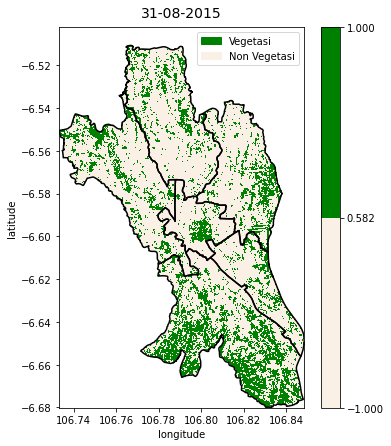

In [18]:
shp_kecamatan = gpd.read_file("Kota Bogor/kecamatan.shp").to_crs(coor_ref)
year, month, date = preprocessed_dir[20:24], preprocessed_dir[25:27], preprocessed_dir[28:30]
time = f"{year}-{month}-{date}"

ndvi = (preprocessed_band[5]-preprocessed_band[4]) / (preprocessed_band[5]+preprocessed_band[4])
class_ndvi = [-1.,nilai_threshold, 1.]
colors = ["linen", "green"]
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_ndvi, len(colors))

fig, ax = plt.subplots(figsize=(6, 7))

ndvi.plot.imshow(ax=ax, cmap=cmap, norm=norm)
shp_kecamatan.boundary.plot(ax=ax, color="black", linestyle="-")
ax.set_title(f"{time[8:]}-{time[5:7]}-{time[:4]}", fontsize=14, pad=10)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

vegetation_patch = mpatches.Patch(color="green", label="Vegetasi")
non_patch = mpatches.Patch(color="linen", label="Non Vegetasi")

plt.legend(handles=[vegetation_patch, non_patch])
plt.show()

# Menyimpan Citra NDVI

````````
year, month, date = preprocessed_dir[20:24], preprocessed_dir[25:27], preprocessed_dir[28:30]
time = f"{year}-{month}-{date}"

if not os.path.exists(f"output/ndvi/{time}"):
    os.makedirs(f"output/ndvi/{time}")

ndvi.rio.to_raster(f"output/ndvi/{time}/ndvi.TIF")
````````

In [19]:
year, month, date = preprocessed_dir[20:24], preprocessed_dir[25:27], preprocessed_dir[28:30]
time = f"{year}-{month}-{date}"

if not os.path.exists(f"output/ndvi/{time}"):
    os.makedirs(f"output/ndvi/{time}")

ndvi.rio.to_raster(f"output/ndvi/{time}/ndvi.TIF")

# Menghitung Luas Area Vegetasi dan Tanpa Vegetasi

In [20]:
ndvi_classed = xr.apply_ufunc(np.digitize, ndvi, class_ndvi)
ndvi_nan = ndvi_classed.where(ndvi_classed != 3)
ndvi_no_veg_area = ndvi.where(ndvi_nan.isin(1)).count().values * 900 / 1000000
ndvi_veg_area = ndvi.where(ndvi_nan.isin(2)).count().values * 900 / 1000000
print('Luas Wilayah Vegetasi', ndvi_veg_area)
print('Luas Wilayah Tanpa Vegetasi', ndvi_no_veg_area)

Luas Wilayah Vegetasi 30.9627
Luas Wilayah Tanpa Vegetasi 85.851


# Membuat file csv Luas Area

````````````
import csv
veg_area_level = pd.DataFrame(columns = ["Date", "No Vegetation", "Vegetation"])
with open('dataset/Luas.csv', 'w') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write a row to the csv file
    writer.writerow(veg_area_level)
f.close()


````````````

# Menyimpan Data Luas Area Kedalam File CSV

````````
import csv
year, month, date = preprocessed_dir[20:24], preprocessed_dir[25:27], preprocessed_dir[28:30]
time = f"{year}-{month}-{date}"
with open("dataset/Luas.csv", newline ="", mode="a") as csv_file:
        writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([time, ndvi_no_veg_area, ndvi_veg_area])
csv_file.close()
````````

In [21]:
import csv
year, month, date = preprocessed_dir[20:24], preprocessed_dir[25:27], preprocessed_dir[28:30]
time = f"{year}-{month}-{date}"
with open("dataset/Luas.csv", newline ="", mode="a") as csv_file:
        writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([time, ndvi_no_veg_area, ndvi_veg_area])
csv_file.close()

# Menampilkan Data Luas Area

In [22]:
df = pd.read_csv("dataset/Luas.csv")
df

,Date,No Vegetation,Vegetation
0,2015-08-31,90.3429,26.4708
1,2016-06-30,85.0572,31.7556
2,2015-08-31,85.8510,30.9627
3,2016-06-30,80.1765,36.6363
4,2017-07-19,74.0331,42.7806
5,2018-09-24,84.0285,32.7897
6,2019-07-25,90.7884,26.0325
7,2019-09-11,93.6099,23.2047
8,2020-05-24,81.3807,35.4231
9,2015-08-31,85.8510,30.9627


# Membuat Sebaran Vegetasi dan Non Vegetasi Berdasarkan Kecamatan

## Mengimport file shp kecamatan di Kota Bogor

In [24]:
shp_bogorbarat = gpd.read_file("dataset/shape/bogorbarat/bogorbarat.shp").to_crs(coor_ref)
shp_bogorselatan = gpd.read_file("dataset/shape/bogorselatan/bogorselatan.shp").to_crs(coor_ref)
shp_bogortengah = gpd.read_file("dataset/shape/bogortengah/bogortengah.shp").to_crs(coor_ref)
shp_bogortimur = gpd.read_file("dataset/shape/bogortimur/bogortimur.shp").to_crs(coor_ref)
shp_bogorutara = gpd.read_file("dataset/shape/bogorutara/bogorutara.shp").to_crs(coor_ref)
shp_tanahsareal = gpd.read_file("dataset/shape/tanahsareal/tanahsareal.shp").to_crs(coor_ref)

In [25]:
ndvi_bogorbarat = ndvi_nan.rio.clip(shp_bogorbarat.geometry.apply(mapping), shp_bogorbarat.crs)
ndvi_bogorselatan = ndvi_nan.rio.clip(shp_bogorselatan.geometry.apply(mapping), shp_bogorselatan.crs)
ndvi_bogortengah = ndvi_nan.rio.clip(shp_bogortengah.geometry.apply(mapping), shp_bogortengah.crs)
ndvi_bogortimur = ndvi_nan.rio.clip(shp_bogortimur.geometry.apply(mapping), shp_bogortimur.crs)
ndvi_bogorutara = ndvi_nan.rio.clip(shp_bogorutara.geometry.apply(mapping), shp_bogorutara.crs)
ndvi_tanahsareal = ndvi_nan.rio.clip(shp_tanahsareal.geometry.apply(mapping), shp_tanahsareal.crs)

bogorbarat_no_veg = ndvi_bogorbarat.where(ndvi_nan.isin(1)).count().values * 900 / 1000000
bogorbarat_veg = ndvi_bogorbarat.where(ndvi_nan.isin(2)).count().values * 900 / 1000000

bogorselatan_no_veg = ndvi_bogorselatan.where(ndvi_nan.isin(1)).count().values * 900 / 1000000
bogorselatan_veg = ndvi_bogorselatan.where(ndvi_nan.isin(2)).count().values * 900 / 1000000


bogortengah_no_veg = ndvi_bogortengah.where(ndvi_nan.isin(1)).count().values * 900 / 1000000
bogortengah_veg = ndvi_bogortengah.where(ndvi_nan.isin(2)).count().values * 900 / 1000000


bogortimur_no_veg = ndvi_bogortimur.where(ndvi_nan.isin(1)).count().values * 900 / 1000000
bogortimur_veg = ndvi_bogortimur.where(ndvi_nan.isin(2)).count().values * 900 / 1000000


bogorutara_no_veg = ndvi_bogorutara.where(ndvi_nan.isin(1)).count().values * 900 / 1000000
bogorutara_veg = ndvi_bogorutara.where(ndvi_nan.isin(2)).count().values * 900 / 1000000

tanahsareal_no_veg = ndvi_tanahsareal.where(ndvi_nan.isin(1)).count().values * 900 / 1000000
tanahsareal_veg = ndvi_tanahsareal.where(ndvi_nan.isin(2)).count().values * 900 / 1000000

In [26]:
print('Luas Wilayah Kecamatan Bogor Barat Kelas Tanpa Vegetasi :',bogorbarat_no_veg)
print('Luas Wilayah Kecamatan Bogor Barat Kelas Vegetasi :', bogorbarat_veg)
print('Luas Wilayah Kecamatan Bogor Selatan Kelas Tanpa Vegetasi :',bogorselatan_no_veg)
print('Luas Wilayah Kecamatan Bogor Selatan Kelas Vegetasi :', bogorselatan_veg)
print('Luas Wilayah Kecamatan Bogor Tengah Kelas Tanpa Vegetasi :',bogortengah_no_veg)
print('Luas Wilayah Kecamatan Bogor Tengah Kelas Vegetasi :', bogortengah_veg)
print('Luas Wilayah Kecamatan Bogor Timur Kelas Tanpa Vegetasi :',bogortimur_no_veg)
print('Luas Wilayah Kecamatan Bogor Timur Kelas Vegetasi :', bogortimur_veg)
print('Luas Wilayah Kecamatan Bogor Utara Kelas Tanpa Vegetasi :',bogorutara_no_veg)
print('Luas Wilayah Kecamatan Bogor Utara Kelas Vegetasi :', bogorutara_veg)
print('Luas Wilayah Kecamatan Tanah Sareal Kelas Tanpa Vegetasi :',tanahsareal_no_veg)
print('Luas Wilayah Kecamatan Tanah Sareal Kelas Vegetasi :', tanahsareal_veg)

Luas Wilayah Kecamatan Bogor Barat Kelas Tanpa Vegetasi : 18.3231
Luas Wilayah Kecamatan Bogor Barat Kelas Vegetasi : 5.076
Luas Wilayah Kecamatan Bogor Selatan Kelas Tanpa Vegetasi : 18.9036
Luas Wilayah Kecamatan Bogor Selatan Kelas Vegetasi : 14.085
Luas Wilayah Kecamatan Bogor Tengah Kelas Tanpa Vegetasi : 6.4872
Luas Wilayah Kecamatan Bogor Tengah Kelas Vegetasi : 1.3176
Luas Wilayah Kecamatan Bogor Timur Kelas Tanpa Vegetasi : 8.4033
Luas Wilayah Kecamatan Bogor Timur Kelas Vegetasi : 2.1357
Luas Wilayah Kecamatan Bogor Utara Kelas Tanpa Vegetasi : 14.8086
Luas Wilayah Kecamatan Bogor Utara Kelas Vegetasi : 4.0914
Luas Wilayah Kecamatan Tanah Sareal Kelas Tanpa Vegetasi : 18.9252
Luas Wilayah Kecamatan Tanah Sareal Kelas Vegetasi : 4.257


## Menampilkan NDVI Per Kecamatan Kota Bogor

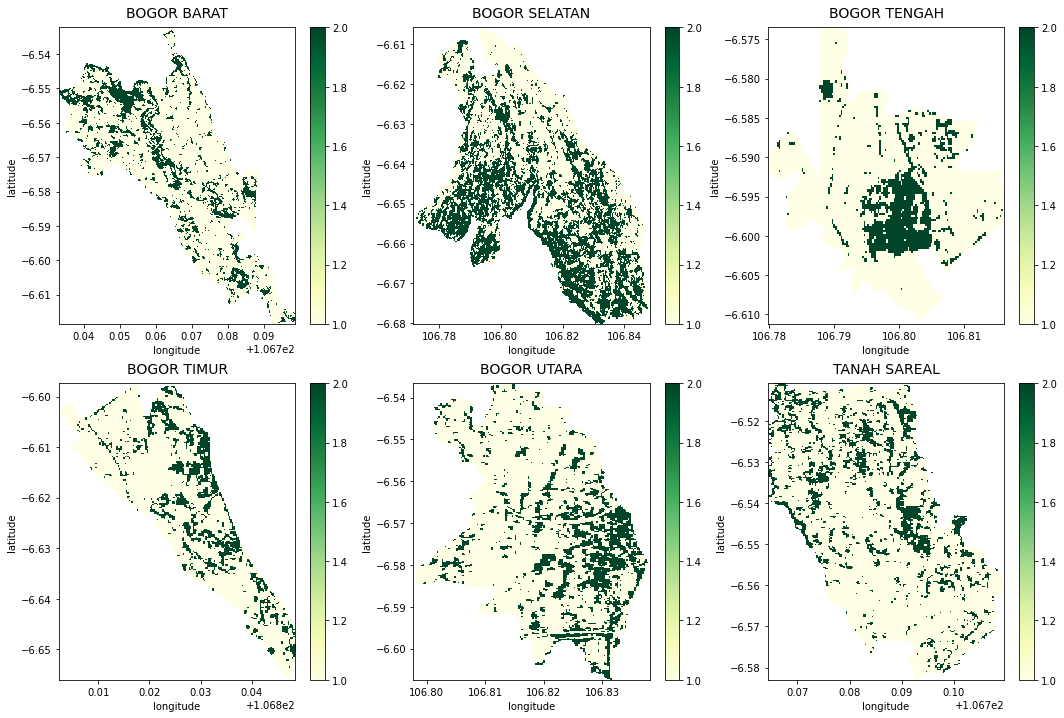

In [27]:
fig, axs=plt.subplots(2, 3, figsize=(18, 12))

ndvi_bogorbarat.plot.imshow(ax=axs[0, 0], cmap="YlGn", vmin=ndvi_nan.min(), vmax=ndvi_nan.max())
axs[0, 0].set_title("BOGOR BARAT", fontsize=14, pad=10)
axs[0, 0].set_xlabel("longitude")
axs[0, 0].set_ylabel("latitude")

ndvi_bogorselatan.plot.imshow(ax=axs[0, 1], cmap="YlGn", vmin=ndvi_nan.min(), vmax=ndvi_nan.max())
axs[0, 1].set_title("BOGOR SELATAN", fontsize=14, pad=10)
axs[0, 1].set_xlabel("longitude")
axs[0, 1].set_ylabel("latitude")

ndvi_bogortengah.plot.imshow(ax=axs[0, 2], cmap="YlGn", vmin=ndvi_nan.min(), vmax=ndvi_nan.max())
axs[0, 2].set_title("BOGOR TENGAH", fontsize=14, pad=10)
axs[0, 2].set_xlabel("longitude")
axs[0, 2].set_ylabel("latitude")

ndvi_bogortimur.plot.imshow(ax=axs[1, 0], cmap="YlGn", vmin=ndvi_nan.min(), vmax=ndvi_nan.max())
axs[1, 0].set_title("BOGOR TIMUR", fontsize=14, pad=10)
axs[1, 0].set_xlabel("longitude")
axs[1, 0].set_ylabel("latitude")

ndvi_bogorutara.plot.imshow(ax=axs[1, 1], cmap="YlGn", vmin=ndvi_nan.min(), vmax=ndvi_nan.max())
axs[1, 1].set_title("BOGOR UTARA", fontsize=14, pad=10)
axs[1, 1].set_xlabel("longitude")
axs[1, 1].set_ylabel("latitude")

ndvi_tanahsareal.plot.imshow(ax=axs[1, 2], cmap="YlGn", vmin=ndvi_nan.min(), vmax=ndvi_nan.max())
axs[1, 2].set_title("TANAH SAREAL", fontsize=14, pad=10)
axs[1, 2].set_xlabel("longitude")
axs[1, 2].set_ylabel("latitude")

plt.show()

## Menyimpan file Citra NDVI Per Kecamatan

In [28]:
year, month, date = preprocessed_dir[20:24], preprocessed_dir[25:27], preprocessed_dir[28:30]
time = f"{year}-{month}-{date}"

if not os.path.exists(f"output/ndvi_kec/{time}"):
    os.makedirs(f"output/ndvi_kec/{time}")

ndvi_bogorbarat.rio.to_raster(f"output/ndvi_kec/{time}/ndvi_bogorbarat.TIF")
ndvi_bogorselatan.rio.to_raster(f"output/ndvi_kec/{time}/ndvi_bogorselatan.TIF")
ndvi_bogortimur.rio.to_raster(f"output/ndvi_kec/{time}/ndvi_bogortimur.TIF")
ndvi_bogortengah.rio.to_raster(f"output/ndvi_kec/{time}/ndvi_bogortengah.TIF")
ndvi_bogorutara.rio.to_raster(f"output/ndvi_kec/{time}/ndvi_bogorutara.TIF")
ndvi_tanahsareal.rio.to_raster(f"output/ndvi_kec/{time}/ndvi_tanahsareal.TIF")

## Membuat file csv luas area vegetasi dan tanpa vegetasi per kecamatan

`````````
import csv
ndvi_kec = pd.DataFrame(columns = ["Date", "Kecamatan", "No Vegetation", "Vegetation"])
with open('dataset/Luas Kecamatan.csv', 'w') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write a row to the csv file
    writer.writerow(ndvi_kec)
f.close()

`````````

In [29]:
import csv
year, month, date = preprocessed_dir[20:24], preprocessed_dir[25:27], preprocessed_dir[28:30]
time = f"{year}-{month}-{date}"
with open("dataset/Luas Kecamatan.csv", newline ="", mode="a") as csv_file:
        writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([time,"Bogor Barat", bogorbarat_no_veg, bogorbarat_veg])
        writer.writerow([time,"Bogor Selatan", bogorselatan_no_veg, bogorselatan_veg])
        writer.writerow([time,"Bogor Tengah", bogortengah_no_veg, bogortengah_veg])
        writer.writerow([time,"Bogor Timur", bogortimur_no_veg, bogortimur_veg])
        writer.writerow([time,"Bogor Utara", bogorutara_no_veg, bogorutara_veg])
        writer.writerow([time,"Tanah Sareal", tanahsareal_no_veg, tanahsareal_veg])
csv_file.close()

```````````
import csv
year, month, date = preprocessed_dir[20:24], preprocessed_dir[25:27], preprocessed_dir[28:30]
time = f"{year}-{month}-{date}"
with open("dataset/Luas Kecamatan.csv", newline ="", mode="a") as csv_file:
        writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([time,"Bogor Barat", bogorbarat_no_veg, bogorbarat_veg])
        writer.writerow([time,"Bogor Selatan", bogorselatan_no_veg, bogorselatan_veg])
        writer.writerow([time,"Bogor Tengah", bogortengah_no_veg, bogortengah_veg])
        writer.writerow([time,"Bogor Timur", bogortimur_no_veg, bogortimur_veg])
        writer.writerow([time,"Bogor Utara", bogorutara_no_veg, bogorutara_veg])
        writer.writerow([time,"Tanah Sareal", tanahsareal_no_veg, tanahsareal_veg])
csv_file.close()
```````````

In [30]:
df = pd.read_csv("dataset/Luas Kecamatan.csv")
df

,Date,Kecamatan,No Vegetation,Vegetation
0,2015-08-31,Bogor Barat,19.1583,4.2408
1,2015-08-31,Bogor Selatan,20.5650,12.4236
2,2015-08-31,Bogor Tengah,6.6285,1.1763
3,2015-08-31,Bogor Timur,8.7804,1.7586
4,2015-08-31,Bogor Utara,15.4566,3.4434
5,2015-08-31,Tanah Sareal,19.7541,3.4281
6,2016-06-30,Bogor Barat,18.1989,5.1921
7,2016-06-30,Bogor Selatan,19.3392,13.6665
8,2016-06-30,Bogor Tengah,6.6051,1.1979
9,2016-06-30,Bogor Timur,8.1297,2.4021
